# Siamese One-Shot-Learning Network, AT&T Faces

In [1]:
import os
import codecs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random
import datetime
import time

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import save_image

## Set Configs

In [3]:
TRAIN_DIR = './datasets/faces/training/'
TEST_DIR = './datasets/faces/testing/'
BATCH_SIZE = 64
N_EPOCHS = 100

In [64]:
# decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and n_gpu > 0) else 'cpu')

## Set Helpers

In [47]:
def show_img(img, text=None, should_save=False):
    
    img = img.numpy()
    plt.figure(figsize=(20,20))
    plt.axis('off')
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
            bbox={'facecolor': 'white', 'aplha': 0.8, 'pad': 10 })
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [5]:
def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

## Configure Custom Data Loader

In [6]:
class SiameseNetworkDataset(torch.utils.data.Dataset):
    
    def __init__(self, datasets, transform=None, should_invert=True):
        self.datasets = datasets
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self, index):
        
        imageA_tupple = random.choice(self.datasets.imgs)
        should_get_same_class = random.randint(0,1) # make sure approx 50% of images are in the same class
        if should_get_same_class:
            while True:
                # keep looping untul the same class image is found
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] == imageB_tupple[1]:
                    break
        else:
            while True:
                # keep looping untill the different class image is found
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] == imageB_tupple[1]:
                    break
                    
        imageA = Image.open(imageA_tupple[0])
        imageB = Image.open(imageB_tupple[0])
        
        imageA = imageA.convert('L')
        imageB = imageB.convert('L')
        
        if self.should_invert:
            imageA = ImageOps.invert(imageA)
            imageB = ImageOps.invert(imageB)
            
        if self.transform is not None:
            imageA = self.transform(imageA)
            imageB = self.transform(imageB)
            
        return imageA, imageB, torch.from_numpy(np.array([int(imageA_tupple[1] != imageB_tupple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.datasets.imgs)

In [7]:
transform = transforms.Compose([
                            transforms.Resize((100,100)),
                            transforms.ToTensor()
])

In [8]:
datasets = datasets.ImageFolder(root=TRAIN_DIR)
siamese_datasets = SiameseNetworkDataset(datasets=datasets,
                                         transform=transform,
                                         should_invert=False)

## Visualize Data

In [41]:
data_loader = DataLoader(siamese_datasets, shuffle=True, num_workers=8, batch_size=BATCH_SIZE)
example_batch = next(iter(data_loader))
print('Batch consists {} data including imageA, imageB and its similariy label.'.format(len(example_batch)))

Batch consists 3 data including imageA, imageB and its similariy label.


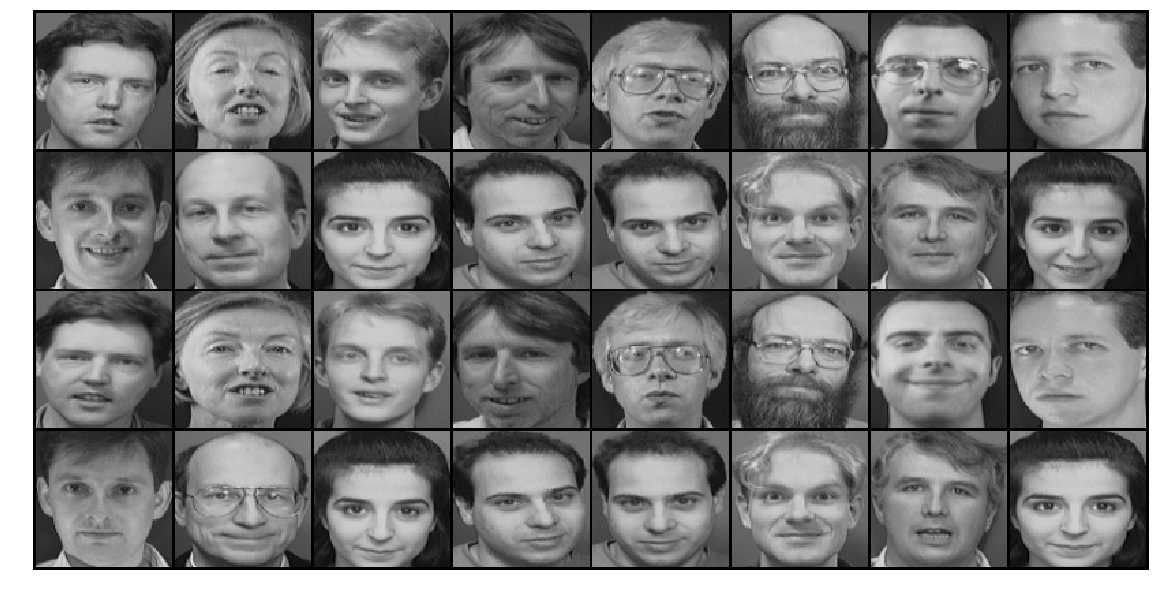

In [59]:
concatenated = torch.cat((example_batch[0][:16], example_batch[1][:16]),0)
show_img(torchvision.utils.make_grid(concatenated))

## Build Siamese Network Architecture

In [62]:
class SiamaseNet(nn.Module):
    
    def __init__(self):
        super(SiamaseNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
        
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),)
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
        
            nn.Linear(500, 5))
        
    def forward_once(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layer(x)
        
        return x
    
    def forward(self, imageA, imageB):
        resultA = self.forward_once(imageA)
        resultB = self.forward_once(imageB)
        
        return resultA, resultB

#### Initialize Siamese Network

In [65]:
siamese = SiamaseNet().to(device)

## Loss Function

In [66]:
class ContrastiveLoss(torch.nn.Module):
    pass

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

---